In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import datetime

In [5]:
dataset = pd.read_csv('../dataset/access_log.txt/output.csv')
dataset.head()

,IP Address,Timestamp,Request,Status
0,10.223.157.186,15-07-2009 14:58,GET / HTTP/1.1,200
1,10.223.157.186,15-07-2009 14:58,GET /favicon.ico HTTP/1.1,200
2,10.223.157.186,15-07-2009 15:50,GET / HTTP/1.1,200
3,10.223.157.186,15-07-2009 15:50,GET /assets/js/lowpro.js HTTP/1.1,200
4,10.223.157.186,15-07-2009 15:50,GET /assets/css/reset.css HTTP/1.1,200


In [6]:
df = dataset.iloc[:580, :]
df.head()

,IP Address,Timestamp,Request,Status
0,10.223.157.186,15-07-2009 14:58,GET / HTTP/1.1,200
1,10.223.157.186,15-07-2009 14:58,GET /favicon.ico HTTP/1.1,200
2,10.223.157.186,15-07-2009 15:50,GET / HTTP/1.1,200
3,10.223.157.186,15-07-2009 15:50,GET /assets/js/lowpro.js HTTP/1.1,200
4,10.223.157.186,15-07-2009 15:50,GET /assets/css/reset.css HTTP/1.1,200


In [7]:
data = {
    "IP_Address": ["10.128.2.1"],
    "Time_Difference_Mean": [99],
    "Time_Difference_Variance": [54],
    "Time_Difference_Sum": [105],
    "Time_Difference_Maximum": [15],
    "Character-bigrams": [45],
    "Character-trigrams": [34],
    "Character-ngrams": [74],
    "Count_of_most_visited_page": [14],
    "Status": [200],
    "Number_of_records": [40],
}
work_dataset = pd.DataFrame(data)
work_dataset

,IP_Address,Time_Difference_Mean,Time_Difference_Variance,Time_Difference_Sum,Time_Difference_Maximum,Character-bigrams,Character-trigrams,Character-ngrams,Count_of_most_visited_page,Status,Number_of_records
0,10.128.2.1,99,54,105,15,45,34,74,14,200,40


In [8]:
import datetime

# import pandas as pd


def time_stats(dataframe):
    """
    Calculate time-based statistics from weblog time format [DD-MM-YYYY HH:MM

    Args:   
        dataframe: pandas DataFrame with time values in format [DD-MM-YYYY HH:MM]
    Returns:
        tuple: (max_time_diff, mean_time_diff, sum_time_diff, variance_time_diff)
    """
    if len(dataframe) <= 1:
        return 0, 0, 0, 0

    # Extract time from the format [DD-MM-YYYY HH:MM]
    def extract_time(time_str):
        return datetime.datetime.strptime(time_str, "%d-%m-%Y %H:%M")

    # Process all times at once
    try:
        processed_times = [
            extract_time(str(time)) for time in dataframe.iloc[:, 1].values
        ]

        # Calculate time differences in seconds
        time_diffs = [
            (processed_times[i] - processed_times[i - 1]).total_seconds()
            for i in range(1, len(processed_times))
        ]

        if not time_diffs:
            return 0, 0, 0, 0

        # Calculate statistics
        max_time_diff = max(time_diffs)
        sum_time_diff = sum(time_diffs)
        mean_time_diff = sum_time_diff / len(time_diffs)

        # Calculate variance
        variance_time_diff = sum(
            (diff - mean_time_diff) ** 2 for diff in time_diffs
        ) / len(time_diffs)

        return max_time_diff, mean_time_diff, sum_time_diff, variance_time_diff

    except (ValueError, IndexError) as e:
        print(f"Error processing times: {e}")
        return 0, 0, 0, 0

In [9]:
time_stats(df)

(1045980.0, 2048.2901554404143, 1185960.0, 1893147251.4805982)

In [10]:
import re
import string
import nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams

In [11]:
def most_frequent(List):
    return max(set(List), key=List.count)

In [12]:
def bigram_stats(dataframe):
    url_array = dataframe.iloc[:, 2].values
    full_string = ""
    for url in url_array:
        full_string = full_string + url
    full_string = full_string.lower()
    full_string = re.sub(r"\d+", "", full_string)
    table = str.maketrans({key: None for key in string.punctuation})
    full_string = full_string.translate(table)
    full_string = full_string.strip()
    full_string_tokens = word_tokenize(full_string)
    for char in full_string_tokens:
        if char == "get":
            full_string_tokens.remove("get")
    for char in full_string_tokens:
        if char == "httpget":
            full_string_tokens.remove("httpget")
    for char in full_string_tokens:
        if char == "httppost":
            full_string_tokens.remove("httppost")
    for char in full_string_tokens:
        if char == "post":
            full_string_tokens.remove("post")

    count_most_visited_page = 0
    if len(full_string_tokens) != 0:
        most_visited_page = most_frequent(full_string_tokens)
        count_most_visited_page = full_string_tokens.count(most_visited_page)

    count_most_appearing_bigram = 0
    bigrams = list(nltk.bigrams(full_string_tokens))
    if len(bigrams) != 0:
        most_appearing_bigram = most_frequent(bigrams)
        count_most_appearing_bigram = bigrams.count(most_appearing_bigram)

    count_most_appearing_trigram = 0
    trigrams = list(nltk.trigrams(full_string_tokens))
    if len(trigrams) != 0:
        most_appearing_trigram = most_frequent(trigrams)
        count_most_appearing_trigram = trigrams.count(most_appearing_trigram)

    count_most_appearing_ngram = 0
    ngrams = list(nltk.ngrams(full_string_tokens, 6))
    if len(ngrams) != 0:
        most_appearing_ngram = most_frequent(ngrams)
        count_most_appearing_ngram = ngrams.count(most_appearing_ngram)

    return (
        count_most_visited_page,
        count_most_appearing_bigram,
        count_most_appearing_trigram,
        count_most_appearing_ngram,
    )

In [13]:
bigram_stats(df)

(68, 21, 7, 2)

In [14]:
from collections import Counter

In [15]:
def most_visited_ip(dataframe):
    ip = dataframe.iloc[:, 0].values
    x = Counter(ip)
    return x.most_common(1)[0][0]

In [16]:
most_visited_ip(df)

'10.216.113.172'

In [17]:
def most_freq_status(dataframe):
    status = dataframe.iloc[:, 3].values
    x = Counter(status)
    return x.most_common(1)[0][0]

In [18]:
most_freq_status(df)

200

In [19]:
print(dataset.columns)

Index(['IP Address', 'Timestamp', 'Request', 'Status'], dtype='object')


In [20]:
# Process dataset
startindex = 0
endindex = 0
prevdate = ""
p = 1

work_dataset = pd.DataFrame(
    columns=[
        "Character-bigrams",
        "Character-ngrams",
        "Character-trigrams",
        "Count_of_most_visited_page",
        "IP_Address",
        "Number_of_records",
        "Status",
        "Time_Difference_Maximum",
        "Time_Difference_Mean",
        "Time_Difference_Sum",
        "Time_Difference_Variance",
    ]
)

for i, row in dataset.iterrows():
    date = row["Timestamp"][:10]  # Extract the date part from the Timestamp
    if i == 0:
        prevdate = date
    else:
        if date == prevdate:
            endindex += 1
        else:
            data = dataset.iloc[startindex : endindex + 1, :]
            max_time_diff, mean_time_diff, sum_time_diff, variance_time_diff = time_stats(data)
            count_most_visited_page, count_most_appearing_bigram, count_most_appearing_trigram, count_most_appearing_ngram = bigram_stats(data)
            most_vis_ip = most_visited_ip(data)
            most_frequent_status = most_freq_status(data)
            most_vis_ip = most_vis_ip if most_vis_ip else "10.130.2.1"
            most_frequent_status = most_frequent_status if most_frequent_status else 200

            work_dataset.loc[p] = [
                count_most_appearing_bigram,
                count_most_appearing_ngram,
                count_most_appearing_trigram,
                count_most_visited_page,
                most_vis_ip,
                endindex - startindex + 1,
                most_frequent_status,
                max_time_diff,
                mean_time_diff,
                sum_time_diff,
                variance_time_diff,
            ]
            startindex = endindex + 1
            endindex = startindex
            prevdate = date
            p += 1

# Process the last date range
data = dataset.iloc[startindex : endindex + 1, :]
max_time_diff, mean_time_diff, sum_time_diff, variance_time_diff = time_stats(data)
count_most_visited_page, count_most_appearing_bigram, count_most_appearing_trigram, count_most_appearing_ngram = bigram_stats(data)
most_vis_ip = most_visited_ip(data)
most_frequent_status = most_freq_status(data)
most_vis_ip = most_vis_ip if most_vis_ip else "10.130.2.1"
most_frequent_status = most_frequent_status if most_frequent_status else 200

work_dataset.loc[p] = [
    count_most_appearing_bigram,
    count_most_appearing_ngram,
    count_most_appearing_trigram,
    count_most_visited_page,
    most_vis_ip,
    endindex - startindex + 1,
    most_frequent_status,
    max_time_diff,
    mean_time_diff,
    sum_time_diff,
    variance_time_diff,
]

In [21]:
work_dataset

,Character-bigrams,Character-ngrams,Character-trigrams,Count_of_most_visited_page,IP_Address,Number_of_records,Status,Time_Difference_Maximum,Time_Difference_Mean,Time_Difference_Sum,Time_Difference_Variance
1,4,1,4,20,10.223.157.186,115,200,18000.0,203.157895,23160.0,2.897527e+06
2,7,2,4,16,10.216.113.172,131,200,3540.0,38.769231,5040.0,1.019000e+05
3,11,1,5,32,10.216.113.172,331,200,33180.0,124.181818,40980.0,3.478052e+06
4,20,3,7,41,10.153.239.5,605,200,31680.0,91.390728,55200.0,2.260375e+06
5,1,1,1,4,10.216.113.172,34,200,37800.0,1376.363636,45420.0,4.229628e+07
...,...,...,...,...,...,...,...,...,...,...,...
315,99,60,87,219,10.208.114.224,3353,200,1140.0,25.739857,86280.0,8.794978e+03
316,169,49,120,275,10.220.112.1,3417,200,1260.0,25.222482,86160.0,7.775770e+03
317,152,94,118,336,10.216.113.172,6946,200,900.0,12.414687,86220.0,2.587474e+03
318,215,115,176,417,10.216.113.172,7991,200,1260.0,10.783479,86160.0,3.044868e+03


In [22]:
Ip_rep = []
for i, row in work_dataset.iterrows():
    ip = str(row.iloc[4])  # Convert to string
    if ip == "nan":  # Handle missing values
        ip = "0.0.0.0"  # Assign a default IP like "0.0.0.0"
    ip = ip.replace(".", "")  # Remove dots
    a = int(ip)  # Convert to integer
    Ip_rep.append(a)  # Append to list

# Convert list to NumPy array and add to DataFrame
work_dataset["IP_rep"] = np.array(Ip_rep)

In [23]:
work_dataset

,Character-bigrams,Character-ngrams,Character-trigrams,Count_of_most_visited_page,IP_Address,Number_of_records,Status,Time_Difference_Maximum,Time_Difference_Mean,Time_Difference_Sum,Time_Difference_Variance,IP_rep
1,4,1,4,20,10.223.157.186,115,200,18000.0,203.157895,23160.0,2.897527e+06,10223157186
2,7,2,4,16,10.216.113.172,131,200,3540.0,38.769231,5040.0,1.019000e+05,10216113172
3,11,1,5,32,10.216.113.172,331,200,33180.0,124.181818,40980.0,3.478052e+06,10216113172
4,20,3,7,41,10.153.239.5,605,200,31680.0,91.390728,55200.0,2.260375e+06,101532395
5,1,1,1,4,10.216.113.172,34,200,37800.0,1376.363636,45420.0,4.229628e+07,10216113172
...,...,...,...,...,...,...,...,...,...,...,...,...
315,99,60,87,219,10.208.114.224,3353,200,1140.0,25.739857,86280.0,8.794978e+03,10208114224
316,169,49,120,275,10.220.112.1,3417,200,1260.0,25.222482,86160.0,7.775770e+03,102201121
317,152,94,118,336,10.216.113.172,6946,200,900.0,12.414687,86220.0,2.587474e+03,10216113172
318,215,115,176,417,10.216.113.172,7991,200,1260.0,10.783479,86160.0,3.044868e+03,10216113172


In [24]:
work_dataset.drop("IP_Address", axis=1, inplace=True)

In [25]:
work_dataset

,Character-bigrams,Character-ngrams,Character-trigrams,Count_of_most_visited_page,Number_of_records,Status,Time_Difference_Maximum,Time_Difference_Mean,Time_Difference_Sum,Time_Difference_Variance,IP_rep
1,4,1,4,20,115,200,18000.0,203.157895,23160.0,2.897527e+06,10223157186
2,7,2,4,16,131,200,3540.0,38.769231,5040.0,1.019000e+05,10216113172
3,11,1,5,32,331,200,33180.0,124.181818,40980.0,3.478052e+06,10216113172
4,20,3,7,41,605,200,31680.0,91.390728,55200.0,2.260375e+06,101532395
5,1,1,1,4,34,200,37800.0,1376.363636,45420.0,4.229628e+07,10216113172
...,...,...,...,...,...,...,...,...,...,...,...
315,99,60,87,219,3353,200,1140.0,25.739857,86280.0,8.794978e+03,10208114224
316,169,49,120,275,3417,200,1260.0,25.222482,86160.0,7.775770e+03,102201121
317,152,94,118,336,6946,200,900.0,12.414687,86220.0,2.587474e+03,10216113172
318,215,115,176,417,7991,200,1260.0,10.783479,86160.0,3.044868e+03,10216113172


In [26]:
X = work_dataset.iloc[:, :].values

In [27]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X = sc_X.fit_transform(X)
X

array([[-0.34918829, -0.2514142 , -0.30262535, ..., -1.4513591 ,
         0.15823905,  0.76783463],
       [-0.33913374, -0.24585779, -0.30262535, ..., -2.0480536 ,
        -0.22087729,  0.7663166 ],
       [-0.32572767, -0.2514142 , -0.29871537, ..., -0.86454366,
         0.2369643 ,  0.7663166 ],
       ...,
       [ 0.14683643,  0.26533133,  0.14311274, ...,  0.62521676,
        -0.23434511,  0.7663166 ],
       [ 0.35798209,  0.38201581,  0.36989177, ...,  0.62324095,
        -0.23428308,  0.7663166 ],
       [ 0.06304847,  0.28200054,  0.14702273, ..., -1.12732633,
        -0.23449357,  0.7663166 ]])

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)

In [29]:
kmeans.fit(X)

KMeans(n_clusters=5, random_state=0)

In [30]:
y_kmeans = kmeans.predict(X)
y_kmeans

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 3, 1, 1, 3, 0, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3,
       3, 3, 1, 3, 1, 1, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 0, 0, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3,
       1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 3, 1, 3, 1,
       1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3,
       1, 1, 1, 3, 3, 3, 1, 0, 2, 4, 4, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 0, 0, 3,
       1, 1, 0, 3, 0, 3, 3, 1, 1, 2, 2, 0, 0, 2, 3,

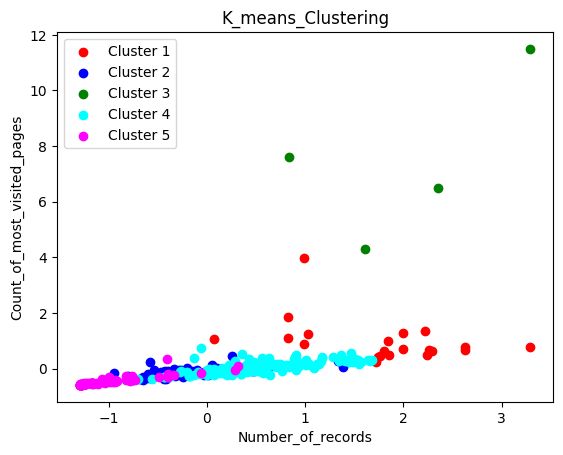

In [31]:
plt.scatter(X[y_kmeans == 0, 4], X[y_kmeans == 0, 3], c="red", label="Cluster 1")
plt.scatter(X[y_kmeans == 1, 4], X[y_kmeans == 1, 3], c="blue", label="Cluster 2")
plt.scatter(X[y_kmeans == 2, 4], X[y_kmeans == 2, 3], c="green", label="Cluster 3")
plt.scatter(X[y_kmeans == 3, 4], X[y_kmeans == 3, 3], c="cyan", label="Cluster 4")
plt.scatter(X[y_kmeans == 4, 4], X[y_kmeans == 4, 3], c="magenta", label="Cluster 5")
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title("K_means_Clustering")
plt.xlabel("Number_of_records")
plt.ylabel("Count_of_most_visited_pages")
plt.legend()
plt.show()

In [32]:
import seaborn as sns

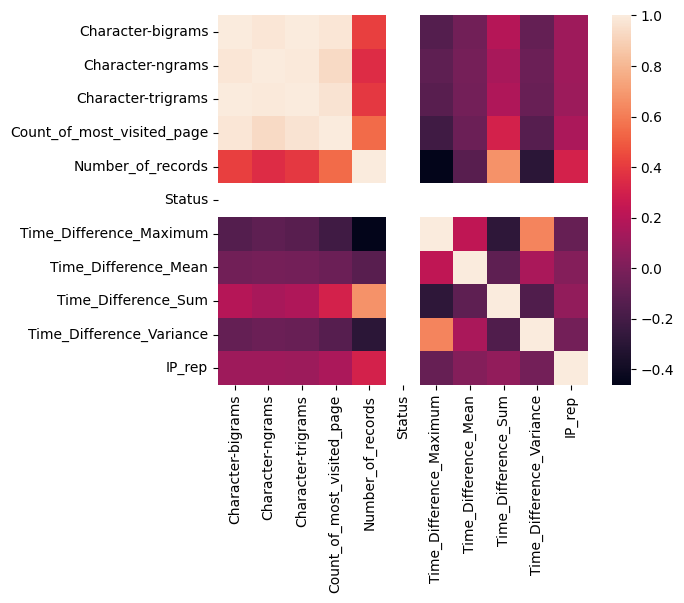

In [33]:
cor = work_dataset.corr()
sns.heatmap(cor, square=True)
plt.show()

In [34]:
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation

In [35]:
model = AgglomerativeClustering(n_clusters=5, metric="euclidean", linkage="ward")
clust_labels1 = model.fit_predict(X)
clust_labels1

array([2, 4, 2, 2, 2, 2, 4, 2, 3, 4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4, 2, 2, 4, 4,
       4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4,
       4, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 2,
       4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,

In [36]:
agglomerative = pd.DataFrame(clust_labels1)

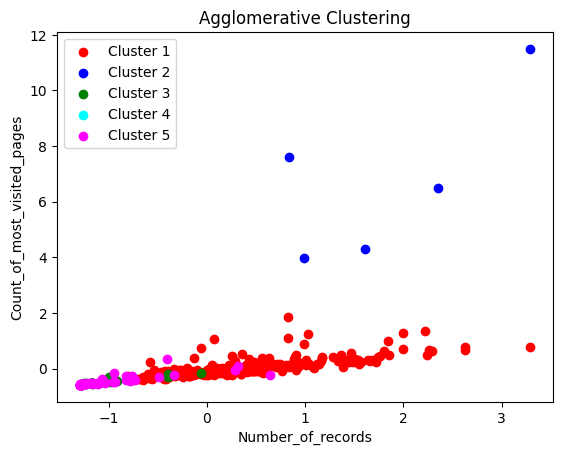

In [37]:
plt.scatter(
    X[clust_labels1 == 0, 4], X[clust_labels1 == 0, 3], c="red", label="Cluster 1"
)
plt.scatter(
    X[clust_labels1 == 1, 4], X[clust_labels1 == 1, 3], c="blue", label="Cluster 2"
)
plt.scatter(
    X[clust_labels1 == 2, 4], X[clust_labels1 == 2, 3], c="green", label="Cluster 3"
)
plt.scatter(
    X[clust_labels1 == 3, 4], X[clust_labels1 == 3, 3], c="cyan", label="Cluster 4"
)
plt.scatter(
    X[clust_labels1 == 4, 4], X[clust_labels1 == 4, 3], c="magenta", label="Cluster 5"
)
plt.title("Agglomerative Clustering")
plt.xlabel("Number_of_records")
plt.ylabel("Count_of_most_visited_pages")
plt.legend()
plt.show()

In [38]:
model_affinity = AffinityPropagation(damping=0.5, max_iter=250, affinity="euclidean")
model_affinity.fit(X)
clust_labels2 = model_affinity.predict(X)
cent2 = model_affinity.cluster_centers_
affinity = pd.DataFrame(clust_labels2)

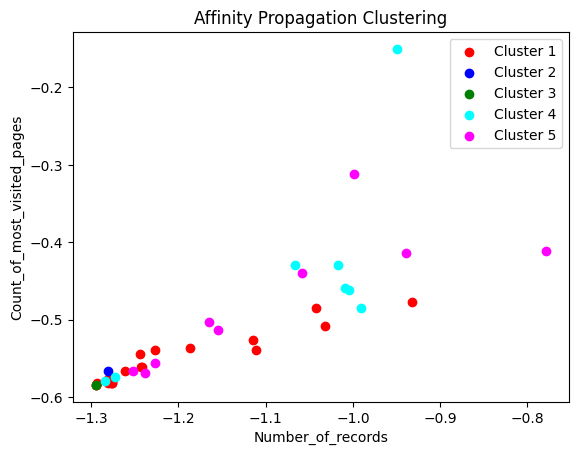

In [39]:
plt.scatter(
    X[clust_labels2 == 0, 4], X[clust_labels2 == 0, 3], c="red", label="Cluster 1"
)
plt.scatter(
    X[clust_labels2 == 1, 4], X[clust_labels2 == 1, 3], c="blue", label="Cluster 2"
)
plt.scatter(
    X[clust_labels2 == 2, 4], X[clust_labels2 == 2, 3], c="green", label="Cluster 3"
)
plt.scatter(
    X[clust_labels2 == 3, 4], X[clust_labels2 == 3, 3], c="cyan", label="Cluster 4"
)
plt.scatter(
    X[clust_labels2 == 4, 4], X[clust_labels2 == 4, 3], c="magenta", label="Cluster 5"
)
plt.title("Affinity Propagation Clustering")
plt.xlabel("Number_of_records")
plt.ylabel("Count_of_most_visited_pages")
plt.legend()
plt.show()

In [40]:
from sklearn.cluster import SpectralClustering

In [41]:
clustering = SpectralClustering(
    n_clusters=5, assign_labels="discretize", random_state=0
).fit(X)
clust_labels3 = clustering.labels_

In [42]:
clust_labels3

array([0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 3,
       3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 0, 3,
       0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3,
       0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0,
       3, 3, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 4, 0, 3, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 2, 0, 0, 4, 0,

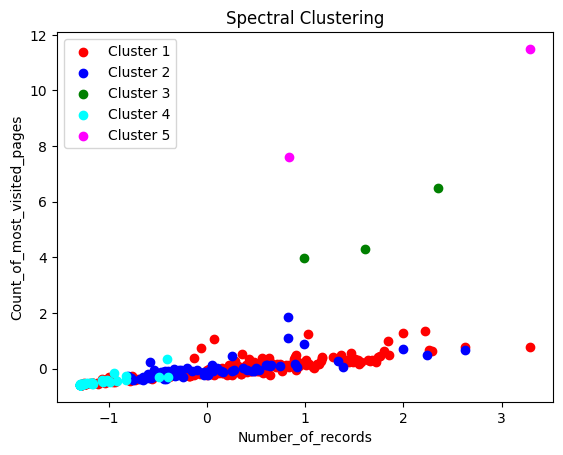

In [43]:
plt.scatter(
    X[clust_labels3 == 0, 4], X[clust_labels3 == 0, 3], c="red", label="Cluster 1"
)
plt.scatter(
    X[clust_labels3 == 1, 4], X[clust_labels3 == 1, 3], c="blue", label="Cluster 2"
)
plt.scatter(
    X[clust_labels3 == 2, 4], X[clust_labels3 == 2, 3], c="green", label="Cluster 3"
)
plt.scatter(
    X[clust_labels3 == 3, 4], X[clust_labels3 == 3, 3], c="cyan", label="Cluster 4"
)
plt.scatter(
    X[clust_labels3 == 4, 4], X[clust_labels3 == 4, 3], c="magenta", label="Cluster 5"
)
plt.title("Spectral Clustering")
plt.xlabel("Number_of_records")
plt.ylabel("Count_of_most_visited_pages")
plt.legend() 
plt.show()

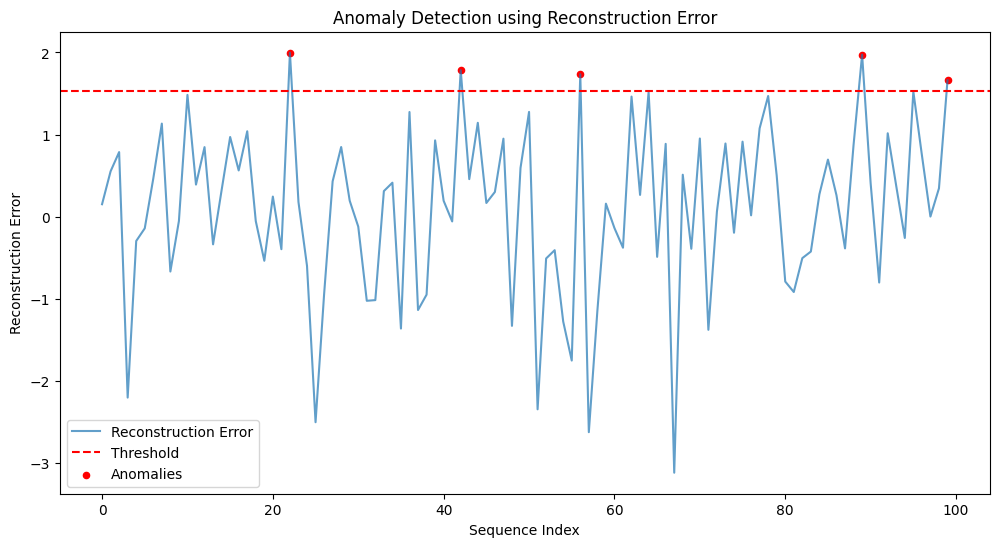

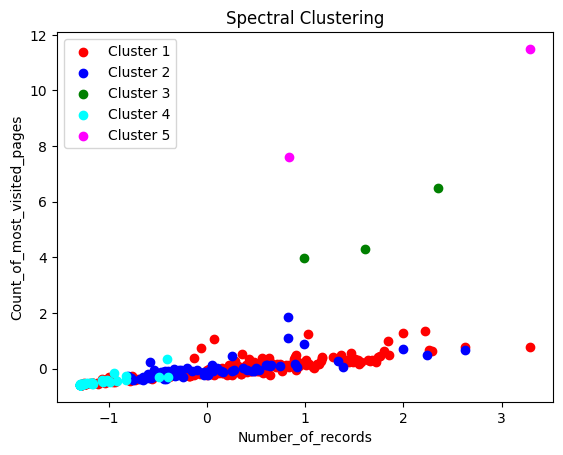

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `errors_np_array` contains the reconstruction errors and `anomalies` is a boolean array indicating anomalies
# Replace these with the actual variables from your anomaly detection code

# Sample data for demonstration (replace with actual data)
errors_np_array = np.random.normal(
    0, 1, 100
)  # Replace with actual reconstruction errors
threshold = np.percentile(errors_np_array, 95)  # Replace with actual threshold
anomalies = errors_np_array > threshold  # Replace with actual anomaly detection logic

# Plot the reconstruction errors and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(errors_np_array, alpha=0.7, label="Reconstruction Error")
plt.axhline(threshold, c="r", linestyle="--", label="Threshold")
plt.scatter(
    np.where(anomalies)[0], errors_np_array[anomalies], c="r", s=20, label="Anomalies"
)
plt.title("Anomaly Detection using Reconstruction Error")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

# Existing clustering plot code
plt.scatter(
    X[clust_labels3 == 0, 4], X[clust_labels3 == 0, 3], c="red", label="Cluster 1"
)
plt.scatter(
    X[clust_labels3 == 1, 4], X[clust_labels3 == 1, 3], c="blue", label="Cluster 2"
)
plt.scatter(
    X[clust_labels3 == 2, 4], X[clust_labels3 == 2, 3], c="green", label="Cluster 3"
)
plt.scatter(
    X[clust_labels3 == 3, 4], X[clust_labels3 == 3, 3], c="cyan", label="Cluster 4"
)
plt.scatter(
    X[clust_labels3 == 4, 4], X[clust_labels3 == 4, 3], c="magenta", label="Cluster 5"
)
plt.title("Spectral Clustering")
plt.xlabel("Number_of_records")
plt.ylabel("Count_of_most_visited_pages")
plt.legend()
plt.show()